In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

torch.cuda.is_available()

True

In [2]:
torch.__version__

'2.0.0'

In [3]:
import h5py

class ParticleDataset(Dataset):
    def __init__(self, file_path=None, X=None, y=None):
        if file_path is not None:
            with h5py.File(file_path, 'r') as f:
                self.X = torch.tensor(f['X'][:], dtype=torch.float32)
                self.y = torch.tensor(f['y'][:], dtype=torch.long)
        else:
            self.X = X
            self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx].permute(2, 0, 1)  # Transpose dimensions to (channels, height, width)
        return x, self.y[idx]

photon_file_path = "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file_path = "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

# Load data from the provided HDF5 files
photon_dataset = ParticleDataset(photon_file_path)
electron_dataset = ParticleDataset(electron_file_path)

In [4]:
from torch.utils.data import DataLoader, SubsetRandomSampler

# Combine the datasets
combined_dataset = torch.utils.data.ConcatDataset([photon_dataset, electron_dataset])

# Create indices for the train/test split
dataset_size = len(combined_dataset)
indices = list(range(dataset_size))
split = int(0.8 * dataset_size)  # 80% training, 20% testing
np.random.shuffle(indices)

train_indices = indices[:split]
test_indices = indices[split:]

# Create samplers for the train/test split
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create dataloaders for training and testing data
train_loader = DataLoader(combined_dataset, batch_size=32, sampler=train_sampler)
test_loader = DataLoader(combined_dataset, batch_size=32, sampler=test_sampler)


In [5]:
photon_dataset.X.shape

torch.Size([249000, 32, 32, 2])

In [6]:
class ParticleClassifier(nn.Module):
    def __init__(self):
        super(ParticleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x


In [55]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.layer1 = self._make_layer(ResBlock, 16, 2, stride=1)
        self.layer2 = self._make_layer(ResBlock, 32, 2, stride=2)
        self.layer3 = self._make_layer(ResBlock, 64, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out


In [56]:
import torch.optim as optim

# Instantiate the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [57]:
# Train the model
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}")


Epoch 1, Loss: 0.6053064936710649
Epoch 2, Loss: 0.5667838150214958
Epoch 3, Loss: 0.5581648376955086
Epoch 4, Loss: 0.5525481698671019
Epoch 5, Loss: 0.5487358337975888
Epoch 6, Loss: 0.5457600672561002
Epoch 7, Loss: 0.543258397440355
Epoch 8, Loss: 0.5409882440169652
Epoch 9, Loss: 0.5390094490750248
Epoch 10, Loss: 0.5375734671196306
Epoch 11, Loss: 0.5358216171140173
Epoch 12, Loss: 0.5339634493962828
Epoch 13, Loss: 0.5328668943203118
Epoch 14, Loss: 0.5312524297713754
Epoch 15, Loss: 0.5298869607103877
Epoch 16, Loss: 0.5286098122860055
Epoch 17, Loss: 0.5272429674696252
Epoch 18, Loss: 0.5257622929294425
Epoch 19, Loss: 0.5241401466416068
Epoch 20, Loss: 0.5226549671859626
Epoch 21, Loss: 0.5213001261178748
Epoch 22, Loss: 0.5198117879068995
Epoch 23, Loss: 0.5181243649795352
Epoch 24, Loss: 0.516425099810922
Epoch 25, Loss: 0.5150359447749264
Epoch 26, Loss: 0.5126033677274443
Epoch 27, Loss: 0.5102588800673025
Epoch 28, Loss: 0.5080899329513431
Epoch 29, Loss: 0.5055547504910

In [ ]:
torch.save(model.state_dict(), "task1_pt.pt")

In [58]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get model probabilities and true labels
def get_probabilities_and_labels(model, data_loader):
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = torch.sigmoid(model(inputs))[:, 1]  # Get probabilities for the positive class
            all_probs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_probs), np.array(all_labels)

# Compute probabilities and true labels
probs, labels = get_probabilities_and_labels(model, test_loader)

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

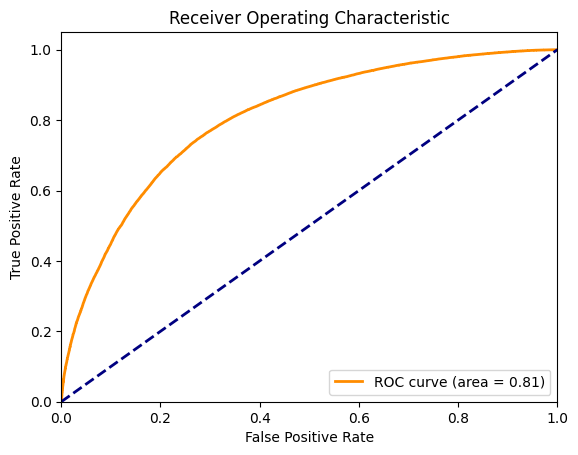

In [59]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
